# The Data

In [62]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, roc_auc_score, cohen_kappa_score, make_scorer, f1_score, accuracy_score

In [63]:
cannabis = pd.read_csv("/Users/oscarluo/Documents/GSB-544/Week_9/cannabis_full.csv")

In [64]:
# Counting NA
cannabis.isna().sum()

Strain         0
Type           0
Rating         0
Effects       87
Flavor       156
            ... 
Pineapple     46
Tar           46
Rose          46
Plum          46
Pear          46
Length: 69, dtype: int64

In [65]:
cannabis = cannabis.dropna()

# Part One: Binary Classification

In [66]:
# Filter for sativa and indica
si = cannabis[(cannabis["Type"] == "sativa") | (cannabis["Type"] == "indica")]

si.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
X = si.drop("Type",axis=1)
y = si["Type"]

# ct

ct = ColumnTransformer(
    [
        # Dummify all categorical columns
        ("dummify", OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=object)),

        # Standardize numerical columns
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    # Keeps any column not specified in ct as is in final output
    remainder='passthrough'  
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [68]:
# LDA
lda_pipeline = Pipeline([
    ("preprocess", ct),
    ("model", LinearDiscriminantAnalysis())
])

# Cross validate LDA
lda_scores = cross_val_score(lda_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Fit the final model
lda_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred_lda = lda_pipeline.predict(X_test)

print("LDA Cross validated Accuracy:", lda_scores.mean())
print("LDA Test Set Evaluation:")
print(classification_report(y_test, y_pred_lda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

LDA Cross validated Accuracy: 0.7871230425055928
LDA Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.78      0.99      0.87       198
      sativa       0.99      0.54      0.69       123

    accuracy                           0.82       321
   macro avg       0.88      0.77      0.78       321
weighted avg       0.86      0.82      0.80       321

Confusion Matrix:
[[197   1]
 [ 57  66]]
LDA Cross validated Accuracy: 0.7871230425055928
LDA Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.78      0.99      0.87       198
      sativa       0.99      0.54      0.69       123

    accuracy                           0.82       321
   macro avg       0.88      0.77      0.78       321
weighted avg       0.86      0.82      0.80       321

Confusion Matrix:
[[197   1]
 [ 57  66]]


In [69]:
# QDA
qda_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", QuadraticDiscriminantAnalysis())  
])

# Cross validate QDA
qda_scores = cross_val_score(qda_pipeline, X_train, y_train, cv=5, scoring="accuracy")
print("QDA Cross-validated Accuracy:", qda_scores.mean())

# Fit the model
qda_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred_qda = qda_pipeline.predict(X_test)

# Output evaluation results
print("QDA Cross validated Accuracy:", qda_scores.mean())
print("QDA Test Set Evaluation:")
print(classification_report(y_test, y_pred_qda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


QDA Cross-validated Accuracy: 0.7187919463087249
QDA Cross-validated Accuracy: 0.7187919463087249


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


QDA Cross validated Accuracy: 0.7187919463087249
QDA Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.80      0.80      0.80       198
      sativa       0.67      0.67      0.67       123

    accuracy                           0.75       321
   macro avg       0.74      0.74      0.74       321
weighted avg       0.75      0.75      0.75       321

Confusion Matrix:
[[158  40]
 [ 40  83]]
QDA Cross validated Accuracy: 0.7187919463087249
QDA Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.80      0.80      0.80       198
      sativa       0.67      0.67      0.67       123

    accuracy                           0.75       321
   macro avg       0.74      0.74      0.74       321
weighted avg       0.75      0.75      0.75       321

Confusion Matrix:
[[158  40]
 [ 40  83]]


In [70]:
# SVC 
svc_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC())  
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    "model__C": [0.1, 1, 10],             
    "model__kernel": ["linear", "rbf"],   
    "model__gamma": ["scale", "auto"]     
}

grid_search = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Fit the model with the best parameters
svc_best = grid_search.best_estimator_
svc_best.fit(X_train, y_train)

# Evaluate on test set
y_pred_svc = svc_best.predict(X_test)

print("Best Parameters for SVC:", grid_search.best_params_)
print("Best Cross-validated Accuracy for SVC:", grid_search.best_score_)
print("SVC Test Set Evaluation:")
print(classification_report(y_test, y_pred_svc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svc))

Best Parameters for SVC: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best Cross-validated Accuracy for SVC: 0.8446532438478747
SVC Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.90      0.93      0.92       198
      sativa       0.89      0.83      0.86       123

    accuracy                           0.89       321
   macro avg       0.89      0.88      0.89       321
weighted avg       0.89      0.89      0.89       321

Confusion Matrix:
[[185  13]
 [ 21 102]]
Best Parameters for SVC: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best Cross-validated Accuracy for SVC: 0.8446532438478747
SVC Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.90      0.93      0.92       198
      sativa       0.89      0.83      0.86       123

    accuracy                           0.89       321
   macro avg       0.89      0.88      0.89       321
weig

In [71]:
#SVM
svm_pipeline = Pipeline([
    ("preprocess", ct), 
    ("model", SVC()) 
])

# Define the hyperparameter grid
param_grid = {
    "model__C": [0.1, 1, 10, 100],          
    "model__kernel": ["linear", "rbf", "poly"],  
    "model__gamma": ["scale", "auto", 0.01, 0.1],  
    "model__degree": [2, 3]  
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=svm_pipeline,  
    param_grid=param_grid,   
    cv=5,                    # Cross-validation folds
    scoring="accuracy",      # Evaluation metric
    verbose=1,               # Print progress
    n_jobs=-1                # Use all available processors
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Evaluate the best model on the test set
svm_best = grid_search.best_estimator_
y_pred_svm = svm_best.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validated Accuracy:", grid_search.best_score_)
print("SVM Test Set Evaluation:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
 

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


Best Parameters: {'model__C': 0.1, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best Cross-validated Accuracy: 0.8446532438478747
SVM Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.90      0.93      0.92       198
      sativa       0.89      0.83      0.86       123

    accuracy                           0.89       321
   macro avg       0.89      0.88      0.89       321
weighted avg       0.89      0.89      0.89       321

Confusion Matrix:
[[185  13]
 [ 21 102]]
Best Parameters: {'model__C': 0.1, 'model__degree': 2, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best Cross-validated Accuracy: 0.8446532438478747
SVM Test Set Evaluation:
              precision    recall  f1-score   support

      indica       0.90      0.93      0.92       198
      sativa       0.89      0.83      0.86       123

    accuracy                           0.89       321
   macro avg       0.89      0.88      0.89       

# Part Two: Natural Multiclass

## Q1. Fit a decision tree, plot the final fit, and interpret the results.

Decision Tree Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.60      0.61      0.60       337
      indica       0.56      0.59      0.57       198
      sativa       0.36      0.33      0.35       123

    accuracy                           0.55       658
   macro avg       0.51      0.51      0.51       658
weighted avg       0.55      0.55      0.55       658

Confusion Matrix:
[[204  75  58]
 [ 68 116  14]
 [ 66  16  41]]
Best Parameters for Decision Tree: {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Decision Tree Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.60      0.61      0.60       337
      indica       0.56      0.59      0.57       198
      sativa       0.36      0.33      0.35       123

    accuracy                           0.55       658
   macro avg       0.51      0.51      0.51       658
weighted avg       0.55      0.55      

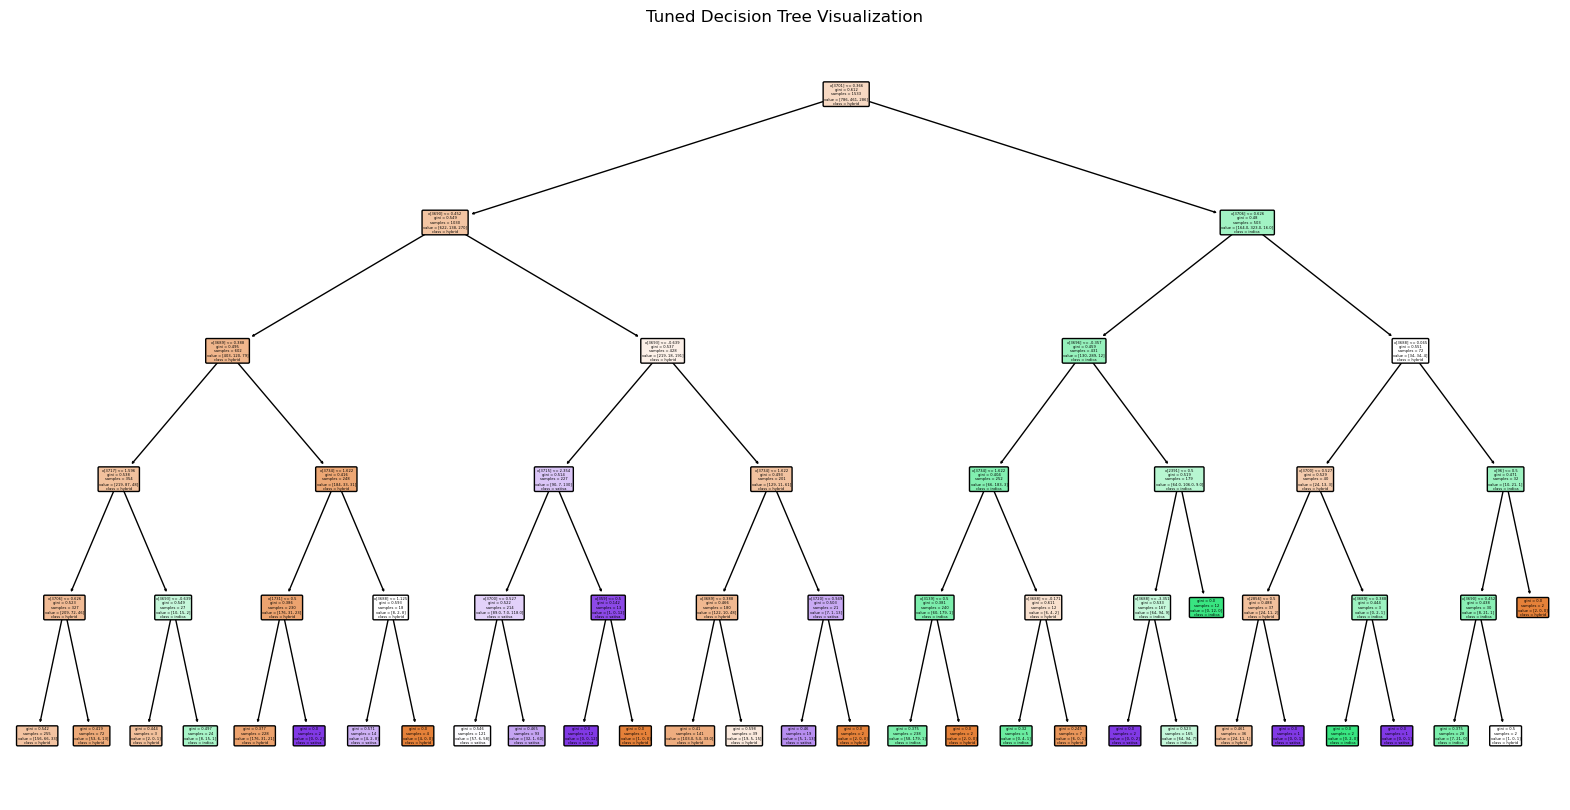

In [72]:
# Decision tree
# Using full dataset 
X = cannabis.drop("Type", axis=1)  
y = cannabis["Type"] 

ct = ColumnTransformer(
    [
        # Dummify all categorical columns
        ("dummify", OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=object)),

        # Standardize numerical columns
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    # Keeps any column not specified in ct as is in final output
    remainder='passthrough'  
)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

dt_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", DecisionTreeClassifier(random_state=42)) 
])

# Fit the pipeline on the training data
dt_pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_tree = dt_pipeline.predict(X_test)

# Hyperparameter Tuning
param_grid = {
    "model__max_depth": [3, 5, 10, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Decision Tree Test Set Evaluation:")
print(classification_report(y_test, y_pred_tree))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))
print("Best Parameters for Decision Tree:", grid_search.best_params_)

# Extract the best Decision Tree model
tuned_tree = grid_search.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(
    tuned_tree.named_steps["model"],     
    class_names=tuned_tree.named_steps["model"].classes_, 
    filled=True,
    rounded=True
)
plt.title("Tuned Decision Tree Visualization")
plt.show()

## Q2. Repeat the analyses from Part One for LDA, QDA, and KNN.

In [73]:
# LDA
lda_pipeline = Pipeline([
    ("preprocess", ct),
    ("model", LinearDiscriminantAnalysis())
])

# Cross validate LDA
lda_scores = cross_val_score(lda_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Fit the final model
lda_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred_lda = lda_pipeline.predict(X_test)

print("LDA Cross validated Accuracy:", lda_scores.mean())
print("LDA Test Set Evaluation:")
print(classification_report(y_test, y_pred_lda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lda))

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Applications/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475,

LDA Cross validated Accuracy: nan
LDA Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.55      0.94      0.69       337
      indica       0.71      0.27      0.39       198
      sativa       1.00      0.01      0.02       123

    accuracy                           0.57       658
   macro avg       0.75      0.41      0.37       658
weighted avg       0.68      0.57      0.48       658

Confusion Matrix:
[[317  20   0]
 [144  54   0]
 [120   2   1]]
LDA Cross validated Accuracy: nan
LDA Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.55      0.94      0.69       337
      indica       0.71      0.27      0.39       198
      sativa       1.00      0.01      0.02       123

    accuracy                           0.57       658
   macro avg       0.75      0.41      0.37       658
weighted avg       0.68      0.57      0.48       658

Confusion Matrix:
[[317  20   0]
 [144  54   0]
 [120   

In [74]:
# QDA
qda_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", QuadraticDiscriminantAnalysis())  
])

# Cross validate QDA
qda_scores = cross_val_score(qda_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Fit the model
qda_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred_qda = qda_pipeline.predict(X_test)

# Output evaluation results
print("QDA Cross validated Accuracy:", qda_scores.mean())
print("QDA Test Set Evaluation:")
print(classification_report(y_test, y_pred_qda))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_qda))

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


QDA Cross validated Accuracy: 0.462532200719593
QDA Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.56      0.25      0.34       337
      indica       0.39      0.54      0.46       198
      sativa       0.26      0.51      0.35       123

    accuracy                           0.38       658
   macro avg       0.41      0.43      0.38       658
weighted avg       0.46      0.38      0.38       658

Confusion Matrix:
[[ 83 133 121]
 [ 36 107  55]
 [ 28  32  63]]
QDA Cross validated Accuracy: 0.462532200719593
QDA Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.56      0.25      0.34       337
      indica       0.39      0.54      0.46       198
      sativa       0.26      0.51      0.35       123

    accuracy                           0.38       658
   macro avg       0.41      0.43      0.38       658
weighted avg       0.46      0.38      0.38       658

Confusion Matrix:
[[ 83 133 

In [75]:
# KNN
knn_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", KNeighborsClassifier())  
])

# Cross validate KNN
knn_scores = cross_val_score(qda_pipeline, X_train, y_train, cv=5, scoring="accuracy")

# Fit the model
knn_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred_knn = knn_pipeline.predict(X_test)

# Output evaluation results
print("KNN Cross-validated Accuracy:", knn_scores.mean())
print("KNN Cross validated Accuracy:", knn_scores.mean())
print("KNN Test Set Evaluation:")
print(classification_report(y_test, y_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


KNN Cross-validated Accuracy: 0.462532200719593
KNN Cross validated Accuracy: 0.462532200719593
KNN Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.55      0.71      0.62       337
      indica       0.52      0.46      0.49       198
      sativa       0.42      0.17      0.24       123

    accuracy                           0.53       658
   macro avg       0.50      0.45      0.45       658
weighted avg       0.52      0.53      0.51       658

Confusion Matrix:
[[240  68  29]
 [107  91   0]
 [ 87  15  21]]
KNN Cross-validated Accuracy: 0.462532200719593
KNN Cross validated Accuracy: 0.462532200719593
KNN Test Set Evaluation:
              precision    recall  f1-score   support

      hybrid       0.55      0.71      0.62       337
      indica       0.52      0.46      0.49       198
      sativa       0.42      0.17      0.24       123

    accuracy                           0.53       658
   macro avg       0.50      0.45      0.

## Q3. Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

The metrics in Part One was generally better than the metrics in Part Two. This is probably because we are differientiating between three categories in Part Two of Hybrid, Indica, and Sativa compared to only two categories in Part One. The category most likely to get mixed up according to the confusion matrices is Hybrid, which may be due to Hyrbid strains having traits that are in Indica and Sativa strains.

# Part Three: Multiclass from Binary

## Q1. Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:

Indica vs. Not Indica

Sativa vs. Not Sativa

Hybrid vs. Not Hybrid

In [76]:
# SVC
# Indica vs. Not Indica
# Create binary target variable
y_indica = (cannabis["Type"] == "indica").astype(int)

# Train-test split
X_train, X_test, y_train_indica, y_test_indica = train_test_split(X, y_indica, test_size=0.25, random_state=42)

svc_indica_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC(random_state=42))  
])
svc_indica_pipeline.fit(X_train, y_train_indica)

# Evaluate model
y_pred_indica = svc_indica_pipeline.predict(X_test)

print("SVC - Indica vs. Not Indica")
print("Confusion Matrix:")
print(confusion_matrix(y_test_indica, y_pred_indica))
print("Classification Report:")
print(classification_report(y_test_indica, y_pred_indica))

SVC - Indica vs. Not Indica
Confusion Matrix:
[[327  51]
 [ 80  90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       378
           1       0.64      0.53      0.58       170

    accuracy                           0.76       548
   macro avg       0.72      0.70      0.71       548
weighted avg       0.75      0.76      0.75       548

SVC - Indica vs. Not Indica
Confusion Matrix:
[[327  51]
 [ 80  90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       378
           1       0.64      0.53      0.58       170

    accuracy                           0.76       548
   macro avg       0.72      0.70      0.71       548
weighted avg       0.75      0.76      0.75       548



In [77]:
# Logistic Regression
# Indica vs. Not Indica
# Create binary target variable
y_indica = (cannabis["Type"] == "indica").astype(int)

# Train-test split
X_train, X_test, y_train_indica, y_test_indica = train_test_split(X, y_indica, test_size=0.25, random_state=42)

svc_indica_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", LogisticRegression(random_state=42))  
])
svc_indica_pipeline.fit(X_train, y_train_indica)

# Evaluate model
y_pred_indica = svc_indica_pipeline.predict(X_test)

print("Logistic Regression - Indica vs. Not Indica")
print("Confusion Matrix:")
print(confusion_matrix(y_test_indica, y_pred_indica))
print("Classification Report:")
print(classification_report(y_test_indica, y_pred_indica))

Logistic Regression - Indica vs. Not Indica
Confusion Matrix:
[[333  45]
 [ 68 102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       378
           1       0.69      0.60      0.64       170

    accuracy                           0.79       548
   macro avg       0.76      0.74      0.75       548
weighted avg       0.79      0.79      0.79       548

Logistic Regression - Indica vs. Not Indica
Confusion Matrix:
[[333  45]
 [ 68 102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       378
           1       0.69      0.60      0.64       170

    accuracy                           0.79       548
   macro avg       0.76      0.74      0.75       548
weighted avg       0.79      0.79      0.79       548



In [78]:
# SVC
# Sativa vs. Not Sativa
#  Create binary target variable
y_sativa = (cannabis["Type"] == "sativa").astype(int)

# Train-test split
X_train, X_test, y_train_sativa, y_test_sativa = train_test_split(X, y_sativa, test_size=0.25, random_state=42)

svc_sativa_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC(random_state=42))  
])
svc_sativa_pipeline.fit(X_train, y_train_sativa)

# Evaluate model
y_pred_sativa = svc_sativa_pipeline.predict(X_test)

print("SVC - Sativa vs. Not Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test_sativa, y_pred_sativa))
print("Classification Report:")
print(classification_report(y_test_sativa, y_pred_sativa))

SVC - Sativa vs. Not Sativa
Confusion Matrix:
[[436  14]
 [ 84  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       450
           1       0.50      0.14      0.22        98

    accuracy                           0.82       548
   macro avg       0.67      0.56      0.56       548
weighted avg       0.78      0.82      0.78       548

SVC - Sativa vs. Not Sativa
Confusion Matrix:
[[436  14]
 [ 84  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       450
           1       0.50      0.14      0.22        98

    accuracy                           0.82       548
   macro avg       0.67      0.56      0.56       548
weighted avg       0.78      0.82      0.78       548



In [89]:
# Logistic Regression
# Sativa vs. Not Sativa
#  Create binary target variable
y_sativa = (cannabis["Type"] == "sativa").astype(int)

# Train-test split
X_train, X_test, y_train_sativa, y_test_sativa = train_test_split(X, y_sativa, test_size=0.25, random_state=42)

lr_sativa_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", LogisticRegression(random_state=42))  
])
lr_sativa_pipeline.fit(X_train, y_train_sativa)

# Evaluate model
y_pred_sativa = lr_sativa_pipeline.predict(X_test)

print("Logistic Regression - Sativa vs. Not Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test_sativa, y_pred_sativa))
print("Classification Report:")
print(classification_report(y_test_sativa, y_pred_sativa))

Logistic Regression - Sativa vs. Not Sativa
Confusion Matrix:
[[418  32]
 [ 66  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       450
           1       0.50      0.33      0.40        98

    accuracy                           0.82       548
   macro avg       0.68      0.63      0.65       548
weighted avg       0.80      0.82      0.81       548

Logistic Regression - Sativa vs. Not Sativa
Confusion Matrix:
[[418  32]
 [ 66  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       450
           1       0.50      0.33      0.40        98

    accuracy                           0.82       548
   macro avg       0.68      0.63      0.65       548
weighted avg       0.80      0.82      0.81       548



In [91]:
# SVC
# Hybrid vs. Not Hybrid
# Create binary target variable
y_hybrid = (cannabis["Type"] == "hybrid").astype(int)

# Train-test split
X_train, X_test, y_train_hybrid, y_test_hybrid = train_test_split(X, y_hybrid, test_size=0.25, random_state=42)

svc_hybrid_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC(random_state=42))  
])
svc_hybrid_pipeline.fit(X_train, y_train_hybrid)

# Evaluate model
y_pred_hybrid = svc_hybrid_pipeline.predict(X_test)

print("SVC - Hybrid vs. Not Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test_hybrid, y_pred_hybrid))
print("Classification Report:")
print(classification_report(y_test_hybrid, y_pred_hybrid))

SVC - Hybrid vs. Not Hybrid
Confusion Matrix:
[[139 129]
 [ 98 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       268
           1       0.59      0.65      0.62       280

    accuracy                           0.59       548
   macro avg       0.59      0.58      0.58       548
weighted avg       0.59      0.59      0.58       548

SVC - Hybrid vs. Not Hybrid
Confusion Matrix:
[[139 129]
 [ 98 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       268
           1       0.59      0.65      0.62       280

    accuracy                           0.59       548
   macro avg       0.59      0.58      0.58       548
weighted avg       0.59      0.59      0.58       548



In [92]:
# Logistic Regression
# Hybrid vs. Not Hybrid
# Create binary target variable
y_hybrid = (cannabis["Type"] == "hybrid").astype(int)

# Train-test split
X_train, X_test, y_train_hybrid, y_test_hybrid = train_test_split(X, y_hybrid, test_size=0.25, random_state=42)

lr_hybrid_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", LogisticRegression(random_state=42))  
])

lr_hybrid_pipeline.fit(X_train, y_train_hybrid)

# Evaluate model
y_pred_sativa = svc_hybrid_pipeline.predict(X_test)

print("Logistic Regression - Hybrid vs. Not Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test_sativa, y_pred_hybrid))
print("Classification Report:")
print(classification_report(y_test_sativa, y_pred_hybrid))

Logistic Regression - Hybrid vs. Not Hybrid
Confusion Matrix:
[[209 241]
 [ 28  70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.46      0.61       450
           1       0.23      0.71      0.34        98

    accuracy                           0.51       548
   macro avg       0.55      0.59      0.48       548
weighted avg       0.76      0.51      0.56       548

Logistic Regression - Hybrid vs. Not Hybrid
Confusion Matrix:
[[209 241]
 [ 28  70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.46      0.61       450
           1       0.23      0.71      0.34        98

    accuracy                           0.51       548
   macro avg       0.55      0.59      0.48       548
weighted avg       0.76      0.51      0.56       548



## Q2. Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

The Logistic Regression model for Indica vs Not Indica performed the best, which suggests that the Indica strain has the most distinct traits. It has the highest precision, recall, and F1 score. On the other hand, Hybrid vs Hybrid performed poorly with both models, which suggests that the Hybrid strain is difficult to distinguish. This makes sense because Hybrid strains carries characteristics from both strains, which makes it harder to distinguish.

## Q3. Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

Indica vs. Sativa

Indica vs. Hybrid

Hybrid vs. Sativa

In [81]:
# SVC
# Indica vs Sativa
indica_sativa_data = cannabis[(cannabis["Type"] == "indica") | (cannabis["Type"] == "sativa")]

# Define features (X) and target (y)
X_indica_sativa = indica_sativa_data.drop("Type", axis=1)
y_indica_sativa = indica_sativa_data["Type"]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_indica_sativa, y_indica_sativa, test_size=0.25, random_state=42, stratify=y_indica_sativa
)

# Create pipeline
indica_sativa_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC(random_state=42))  
])

# Fit the pipeline
indica_sativa_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = indica_sativa_pipeline.predict(X_test)

# Evaluate the model
print("SVC - Indica vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC - Indica vs. Sativa
Confusion Matrix:
[[153  12]
 [ 20  82]]
Classification Report:
              precision    recall  f1-score   support

      indica       0.88      0.93      0.91       165
      sativa       0.87      0.80      0.84       102

    accuracy                           0.88       267
   macro avg       0.88      0.87      0.87       267
weighted avg       0.88      0.88      0.88       267

SVC - Indica vs. Sativa
Confusion Matrix:
[[153  12]
 [ 20  82]]
Classification Report:
              precision    recall  f1-score   support

      indica       0.88      0.93      0.91       165
      sativa       0.87      0.80      0.84       102

    accuracy                           0.88       267
   macro avg       0.88      0.87      0.87       267
weighted avg       0.88      0.88      0.88       267



In [82]:
# SVC
# Indica vs Sativa
indica_sativa_data = cannabis[(cannabis["Type"] == "indica") | (cannabis["Type"] == "sativa")]

# Define features (X) and target (y)
X_indica_sativa = indica_sativa_data.drop("Type", axis=1)
y_indica_sativa = indica_sativa_data["Type"]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_indica_sativa, y_indica_sativa, test_size=0.25, random_state=42, stratify=y_indica_sativa
)

# Create pipeline
indica_sativa_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", LogisticRegression(random_state=42))  
])

# Fit the pipeline
indica_sativa_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = indica_sativa_pipeline.predict(X_test)

# Evaluate the model
print("Logistic Regression - Indica vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression - Indica vs. Sativa
Confusion Matrix:
[[150  15]
 [ 21  81]]
Classification Report:
              precision    recall  f1-score   support

      indica       0.88      0.91      0.89       165
      sativa       0.84      0.79      0.82       102

    accuracy                           0.87       267
   macro avg       0.86      0.85      0.86       267
weighted avg       0.86      0.87      0.86       267

Logistic Regression - Indica vs. Sativa
Confusion Matrix:
[[150  15]
 [ 21  81]]
Classification Report:
              precision    recall  f1-score   support

      indica       0.88      0.91      0.89       165
      sativa       0.84      0.79      0.82       102

    accuracy                           0.87       267
   macro avg       0.86      0.85      0.86       267
weighted avg       0.86      0.87      0.86       267



In [83]:
# SVC
# Indica vs. Hybrid
indica_hybrid_data = cannabis[(cannabis["Type"] == "indica") | (cannabis["Type"] == "hybrid")]

# Define features (X) and target (y)
X_indica_hybrid = indica_hybrid_data.drop("Type", axis=1)
y_indica_hybrid = indica_hybrid_data["Type"]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_indica_hybrid, y_indica_hybrid, test_size=0.25, random_state=42, stratify=y_indica_hybrid
)

# Create pipeline
indica_hybrid_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC(random_state=42))  
])

# Fit the pipeline
indica_hybrid_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = indica_hybrid_pipeline.predict(X_test)

# Evaluate the model
print("SVC - Indica vs. Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC - Indica vs. Hybrid
Confusion Matrix:
[[222  59]
 [ 65 100]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.77      0.79      0.78       281
      indica       0.63      0.61      0.62       165

    accuracy                           0.72       446
   macro avg       0.70      0.70      0.70       446
weighted avg       0.72      0.72      0.72       446

SVC - Indica vs. Hybrid
Confusion Matrix:
[[222  59]
 [ 65 100]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.77      0.79      0.78       281
      indica       0.63      0.61      0.62       165

    accuracy                           0.72       446
   macro avg       0.70      0.70      0.70       446
weighted avg       0.72      0.72      0.72       446



In [84]:
# Logistic Regression
# Indica vs. Hybrid
indica_hybrid_data = cannabis[(cannabis["Type"] == "indica") | (cannabis["Type"] == "hybrid")]

# Define features (X) and target (y)
X_indica_hybrid = indica_hybrid_data.drop("Type", axis=1)
y_indica_hybrid = indica_hybrid_data["Type"]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_indica_hybrid, y_indica_hybrid, test_size=0.25, random_state=42, stratify=y_indica_hybrid
)

# Create pipeline
indica_hybrid_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", LogisticRegression(random_state=42))  
])

# Fit the pipeline
indica_hybrid_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = indica_hybrid_pipeline.predict(X_test)

# Evaluate the model
print("Logistic Regression - Indica vs. Hybrid")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression - Indica vs. Hybrid
Confusion Matrix:
[[225  56]
 [ 65 100]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.78      0.80      0.79       281
      indica       0.64      0.61      0.62       165

    accuracy                           0.73       446
   macro avg       0.71      0.70      0.71       446
weighted avg       0.73      0.73      0.73       446

Logistic Regression - Indica vs. Hybrid
Confusion Matrix:
[[225  56]
 [ 65 100]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.78      0.80      0.79       281
      indica       0.64      0.61      0.62       165

    accuracy                           0.73       446
   macro avg       0.71      0.70      0.71       446
weighted avg       0.73      0.73      0.73       446



In [85]:
# SVC
# Hybrid vs. Sativa
hybrid_sativa_data = cannabis[(cannabis["Type"] == "hybrid") | (cannabis["Type"] == "sativa")]

# Define features (X) and target (y)
X_hybrid_sativa = hybrid_sativa_data.drop("Type", axis=1)
y_hybrid_sativa = hybrid_sativa_data["Type"]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_hybrid_sativa, y_hybrid_sativa, test_size=0.25, random_state=42, stratify=y_hybrid_sativa
)

# Create pipeline
hybrid_sativa_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", SVC(random_state=42))  
])

# Fit the pipeline
hybrid_sativa_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = hybrid_sativa_pipeline.predict(X_test)

# Evaluate the model
print("SVC - Hybrid vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

SVC - Hybrid vs. Sativa
Confusion Matrix:
[[265  16]
 [ 82  20]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.76      0.94      0.84       281
      sativa       0.56      0.20      0.29       102

    accuracy                           0.74       383
   macro avg       0.66      0.57      0.57       383
weighted avg       0.71      0.74      0.70       383

SVC - Hybrid vs. Sativa
Confusion Matrix:
[[265  16]
 [ 82  20]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.76      0.94      0.84       281
      sativa       0.56      0.20      0.29       102

    accuracy                           0.74       383
   macro avg       0.66      0.57      0.57       383
weighted avg       0.71      0.74      0.70       383



In [86]:
# Logistic Regression
# Hybrid vs. Sativa
hybrid_sativa_data = cannabis[(cannabis["Type"] == "hybrid") | (cannabis["Type"] == "sativa")]

# Define features (X) and target (y)
X_hybrid_sativa = hybrid_sativa_data.drop("Type", axis=1)
y_hybrid_sativa = hybrid_sativa_data["Type"]

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_hybrid_sativa, y_hybrid_sativa, test_size=0.25, random_state=42, stratify=y_hybrid_sativa
)

# Create pipeline
hybrid_sativa_pipeline = Pipeline([
    ("preprocess", ct),  
    ("model", LogisticRegression(random_state=42))  
])

# Fit the pipeline
hybrid_sativa_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = hybrid_sativa_pipeline.predict(X_test)

# Evaluate the model
print("Logistic Regression - Hybrid vs. Sativa")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression - Hybrid vs. Sativa
Confusion Matrix:
[[249  32]
 [ 67  35]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.79      0.89      0.83       281
      sativa       0.52      0.34      0.41       102

    accuracy                           0.74       383
   macro avg       0.66      0.61      0.62       383
weighted avg       0.72      0.74      0.72       383

Logistic Regression - Hybrid vs. Sativa
Confusion Matrix:
[[249  32]
 [ 67  35]]
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.79      0.89      0.83       281
      sativa       0.52      0.34      0.41       102

    accuracy                           0.74       383
   macro avg       0.66      0.61      0.62       383
weighted avg       0.72      0.74      0.72       383



## Q4. Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

Logistic Regression model for Indica vs Sativa did the best based on the metrics, which makes sense because Indica and Sativa has the most different characteristics. SVC for Hybrid vs Sativa performed the worst based on metrics, which makes sense because SVC's generally performs poorly with heavy overlaps.

## Q5. Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach? What about for SVC?

When the Logistic Regression function is used with the full data with three classes, this would automatically take an OvR approach. This trains one classifier for each class. On the other hand, SVC automatically takes an OvO approach, which will train separate classifiers for every pair of classes.